In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas_profiling import ProfileReport

In [2]:
df = pd.read_csv("covid19weekly.csv", parse_dates=[4])

### Basic Details

The dataset has 29 observations with 11 features

In [3]:
df.shape

(29, 11)

In [4]:
df.head()

,X,Y,objectid,globalid,enter_web_posting_date,week_duration,weekly_bexar_county_total_tests,weekly_bexar_county_negative_an,weekly_bexar_county_positive_te,percent_weekly_bexar_county_pos,number_of_labs_included
0,0.0,0.0,1,{46EC6745-37B4-4B0F-8F0F-A2AAAE09B539},2020-04-05 17:00:00,3/30 - 4/5,3378,2987,391,11.6,10
1,0.0,0.0,2,{6B5C3442-9887-4ABD-873F-1B28CFD4C16C},2020-04-12 17:00:00,4/6 - 4/12,3149,2888,261,8.3,12
2,0.0,0.0,3,{60B25B85-D57E-48CA-8848-EA44CC2207D7},2020-04-19 17:00:00,4/13 - 4/19,5158,4916,242,4.7,14
3,0.0,0.0,4,{ED459847-8569-40BA-82A0-679AD3C4771A},2020-04-26 17:00:00,4/20 - 4/26,7560,7125,435,5.8,17
4,0.0,0.0,5,{E9D344A4-3967-44DB-80B7-2A45E364C32F},2020-05-03 17:00:00,4/27 - 5/3,7000,6604,396,5.7,17


What are the `X` and `Y` columns? These columns don't seem to provide any information.

In [5]:
print("X values\n==========")
print(df["X"].value_counts())
print("Y values\n==========")
print(df["Y"].value_counts())

X values
0.0    29
Name: X, dtype: int64
Y values
0.0    29
Name: Y, dtype: int64


The `week_duration` column was written in a way that isn't very helpul for analysis:

In [6]:
df.week_duration

0      3/30 - 4/5
1      4/6 - 4/12
2     4/13 - 4/19
3     4/20 - 4/26
4      4/27 - 5/3
5      5/4 - 5/10
6     5/11 - 5/17
7     5/17 - 5/23
8     5/24 - 5/30
9      5/31 - 6/6
10    6/07 - 6/13
11    6/14 - 6/20
12    6/21 - 6/27
13     6/28 - 7/4
14     7/5 - 7/11
15      7/12-7/18
16      7/19-7/25
17     7/26 - 8/1
18      8/2 - 8/8
19     8/9 - 8/15
20      8/16-8/22
21      8/23-8/29
22     8/30 - 9/5
23    9/16 - 9/12
24      9/13-9/19
25      9/20-9/26
26      9/27-10/3
27     10/4-10/10
28    10/11-10/17
Name: week_duration, dtype: object

The 24th `week_duration` entry is reversed, pandas can be used to replace it in all in one function

In [7]:
def separate_date_range(date_range):
    """
    Return a pandas Series object with Timedelta duration in days
    """
    ptn = r"(\d+\/\d+)[\-\s]+(\d+\/\d+)"
    start = pd.to_datetime(date_range.str.replace(ptn, "\g<1>/2020"))
    end = pd.to_datetime(date_range.str.replace(ptn, "\g<2>/2020"))
    
    # flip date ranges that are in the wrong order
    check = pd.DataFrame({"start": start, "end": end}).values
    check = np.sort(check, axis=1)
    
    duration = pd.DataFrame(check, columns=["start", "end"])
    duration = duration.end - duration.start
    
    return duration

Not entirely revelatory, but it looks like the 29 testing periods were almost exclusively 6-day weeks.

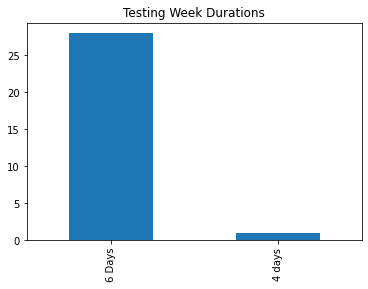

In [8]:
df["duration_days"] = separate_date_range(df["week_duration"])
df["duration_days"].value_counts().plot.bar()
plt.xticks(ticks=range(2), labels=["6 Days", "4 days"])
plt.title("Testing Week Durations");

What are the date ranges for this testing data? It appears that the data contains 29 weeks of testing from
April 5th, 2020 to October 18th, 2020.

In [9]:
print("There are {} unique entry dates".format(df["enter_web_posting_date"].nunique()))
print("The earliest date: {}".format(df["enter_web_posting_date"].min()))
print("The latest date: {}".format(df["enter_web_posting_date"].max()))

There are 29 unique entry dates
The earliest date: 2020-04-05 17:00:00
The latest date: 2020-10-18 17:00:00


In [10]:
df.describe()

,X,Y,objectid,weekly_bexar_county_total_tests,weekly_bexar_county_negative_an,weekly_bexar_county_positive_te,percent_weekly_bexar_county_pos,number_of_labs_included,duration_days
count,29.0,29.0,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29
mean,0.0,0.0,15.586207,12037.724138,10575.482759,1462.241379,9.886897,19.172414,5 days 22:20:41.379310344
std,0.0,0.0,8.946337,5524.438794,4087.201703,1598.994609,6.359232,4.045005,0 days 08:54:48.154436994
min,0.0,0.0,1.000000,3149.000000,2888.000000,242.000000,3.500000,10.000000,4 days 00:00:00
25%,0.0,0.0,8.000000,9110.000000,8559.000000,396.000000,5.700000,15.000000,6 days 00:00:00
50%,0.0,0.0,16.000000,11074.000000,10473.000000,647.000000,6.700000,21.000000,6 days 00:00:00
75%,0.0,0.0,23.000000,13415.000000,12151.000000,1707.000000,12.700000,23.000000,6 days 00:00:00
max,0.0,0.0,30.000000,24437.000000,19060.000000,5377.000000,24.200000,23.000000,6 days 00:00:00


Object id #13 is missing, it goes up to 30 but there are only 29 observations

In [11]:
sorted(df["objectid"].value_counts().index)

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

### Plots

How have positive tests changed over the year?

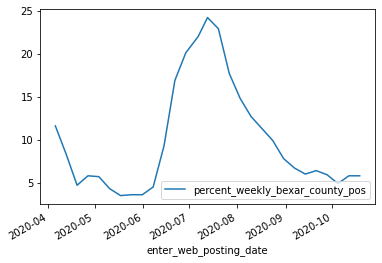

In [12]:
df.plot(x="enter_web_posting_date", y="percent_weekly_bexar_county_pos");

What do the proportions of tests look like in relation to the total?

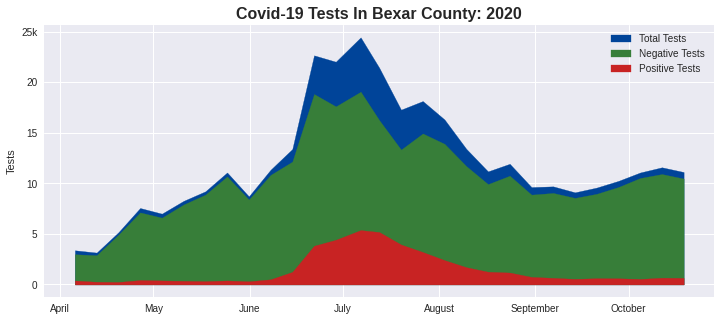

In [19]:
plt.style.use("seaborn")

months_fmt = mdates.DateFormatter("%B")
labels = ["Total", "Negative", "Positive"]
months = ["Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct"]

fig, ax = plt.subplots(figsize=(12, 5))

ax.fill_between(df["enter_web_posting_date"],
                df["weekly_bexar_county_total_tests"], 0, 
                color="#004499", label="Total Tests")
ax.fill_between(df["enter_web_posting_date"],
                df["weekly_bexar_county_negative_an"], 0, 
                color="#377E39", label="Negative Tests")
ax.fill_between(df["enter_web_posting_date"],
                df["weekly_bexar_county_positive_te"], 0, 
                color="#C82323", label="Positive Tests")

ax.xaxis.set_major_formatter(months_fmt)

plt.yticks(ticks=range(0, 25001, 5000),labels=["0", "5", "10", "15", "20", "25k"])
plt.ylabel("Tests")

plt.title("Covid-19 Tests In Bexar County: 2020", size=16, weight="bold")
plt.legend()
plt.show();